Looking at the drifter data from Mark. Trying to determine dates and locations of releases.

In [53]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime as dt

from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools

from __future__ import division

In [2]:

drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']
ios=drifters['ios']

In [3]:

grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:, :]
X = grid.variables['nav_lon'][:, :]
Y = grid.variables['nav_lat'][:, :]


# Retrieving deploy times and positions

In [4]:
def convert_time(matlab_time_array):
    "converts a matlab time array to python format"
    python_time_array=[]
    for t in matlab_time_array:
        python_datetime = dt.datetime.fromordinal(int(t)) + dt.timedelta(days=t%1) - dt.timedelta(days = 366)
        python_time_array.append(python_datetime)
    
    python_time_array = np.array(python_time_array)
    return python_time_array

In [5]:
def get_tracks(switch,lats,lons,ptime,in_water):
    """returns a list of tracks of each buoy, ie a trajectory for each time the buoy was released into the water"""
    all_tracks=[]
    for ind in switch:
        track_on = 1
        i = ind
        track ={'time':[], 'lat':[],'lon':[]}
        while(track_on):
            if in_water[i]!=1:
                track_on=0
            elif i==np.shape(in_water)[0]-1:    
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
                track_on=0
            else:
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
            i=i+1
        all_tracks.append(track)
        
    return all_tracks

In [6]:
def organize_info(buoy,btype):
    """ organizes the buoy info. Groups the buoy data into tracks for when it was released into the water. """
    #creat arrays for easier access
    buoy_name = btype[buoy][0]
    lats = btype[buoy]['lat'].flatten()
    lons = btype[buoy]['lon'].flatten()
    mtime = btype[buoy]['mtime']
    in_water = btype[buoy]['isSub'].flatten()
    #convert mtime to python datetimes
    ptime = convert_time(mtime)
    
    #loop through in_water flag to find when buoy switched from being out of water to being in water. 
    switch = []; 
    for ind in np.arange(1,in_water.shape[0]):
        if int(in_water[ind]) != int(in_water[ind-1]):
            if int(in_water[ind])==1:
                switch.append(ind)
    
    all_tracks=get_tracks(switch,lats,lons,ptime.flatten(),in_water)
    
    return buoy_name, all_tracks

In [7]:
def print_info(buoy,btype):
    """ prints the release time, lat, lon, and duration of a buoy track"""
    name, tracks=organize_info(buoy,btype)
    print name
    print 'Release times, positions and duration in hours'
    for t in tracks:
        print t['time'][0], t['lat'][0], t['lon'][0], (t['time'][-1]-t['time'][0]).total_seconds()/3600

In [8]:
def find_start(tracks, start_date):
    """returns the a list of indices for a track released on start date.
    Only checks the month and day of the start day"""
    i=0
    ind=[]
    starttimes=[]
    for t in tracks:   
        if int(t['time'][0].month) == start_date.month:
                if int(t['time'][0].day) == start_date.day:
                    ind.append(i)
        i=i+1
        
    return ind

In [72]:
def plot_buoy(ax, tracks, startdate, i=0, fancy=False):
    """ plots a buoy trajectory at the given startdate in an axis, ax.
    returns the trajectory that was plotted.
    The first track released on the startdate is plotted.
    For trajectories that were released mulitples times a day, i selects which release is plotted.
    """
    ind =find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print 'Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours'
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    
    [j,i]=tidetools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,bathy)
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    if fancy:
        cmap = plt.get_cmap('winter_r')
        cmap.set_bad('burlywood')
        ax.pcolormesh(X, Y, bathy, cmap=cmap)
        ax.set_title('Observed Drift Track')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.text(-123.15,49.13, "Fraser River", fontsize=12)
    else:
        viz_tools.plot_coastline(ax, grid, coords='map')
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
        print 'NEMO coords:', j,i
    return traj

In [10]:
def plot_tides(ax,relase_times,start,end):
    """Plots the the tides at Point Atkinson between start and end , highlighting the release times 
    listed in relase_times."""
    wlev = stormtools.load_observations(start, end,'PointAtkinson')
    ax.plot(wlev.time,wlev.slev,'-k')
    for t in release_times:
        ax.plot([t,t],[0,5],'-')
    ax.set_xlim(dt.datetime.strptime(start,'%d-%b-%Y'),dt.datetime.strptime(end,'%d-%b-%Y'))
    ax.set_ylim([0,5])
    ax.set_ylabel('Water level (m)')
    ax.set_xlabel('time (UTC)')
    ax.set_title('Observed water level at Point Atkinson ' + start +'-'+ end)

In [11]:
def plot_winds(ax_speed,ax_dir,release_times,start,end):
    """Plots Sandheads winds between start and end. Highlights release times listed in release_times"""
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)
    ax=ax_speed
    ax.plot(time,wind_speed,'-k')
    for t in release_times:
        ax.plot([t,t],[0,10],'-')
    ax.set_xlim(dt.datetime.strptime(start,'%d-%b-%Y'),dt.datetime.strptime(end,'%d-%b-%Y'))
    ax.set_ylim([0,10])
    ax.set_ylabel('Wind Speed (m/s)')
    ax.set_title('Observed wind speed at Sandheads ' + start +'-'+ end)
    ax=ax_dir
    ax.plot(time,wind_dir,'-k')
    for t in release_times:
        ax.plot([t,t],[0,360],'-')
    ax.set_xlim(dt.datetime.strptime(start,'%d-%b-%Y'),dt.datetime.strptime(end,'%d-%b-%Y'))
    ax.set_ylim([0,350])
    ax.set_ylabel('Wind Direction (deg CCW of E)')
    ax.set_title('Observed wind direction at Sandheads ' + start +'-'+ end)

# UBC Buoys

First, print some information about each buoy.

In [12]:
for num in np.arange(0,ubc.shape[0]):
    print_info(num,ubc)

UBC-I-0001
Release times, positions and duration in hours
2014-08-21 16:40:04.999997 49.1632016667 -123.358991667 0.667500000556
2014-08-21 17:50:08.000002 49.1600033333 -123.365111667 0.833333334167
2014-08-21 19:05:07.999996 49.1571733333 -123.359418333 0.999722222778
2014-08-21 20:45:06.999996 49.1571983333 -123.360888333 1.00138888861
2014-08-21 22:00:08.999998 49.1548316667 -123.366338333 1.00000000194
2014-08-28 16:30:05.000003 49.2163283333 -123.355693333 0.917499999444
2014-08-28 18:10:08.999996 49.2151716667 -123.364878333 1.17055555722
2014-08-28 19:40:08.000001 49.2150016667 -123.363986667 1.16638888806
2014-08-28 21:15:08.000004 49.2174433333 -123.365893333 0.583333331944
2014-09-04 16:30:07.999997 49.1352766667 -123.333071667 0.666666668889
2014-09-04 17:40:07.999998 49.1345266667 -123.337721667 0.75
2014-09-04 19:00:10.999997 49.1348083333 -123.338661667 0.832499999722
2014-09-04 20:10:08.000005 49.1353116667 -123.337346667 0.583333331944
2014-09-04 21:05:07.000005 49.140

# IOS Buoys

In [13]:
for num in np.arange(0,ios.shape[0]):
    print_info(num,ios)

51
Release times, positions and duration in hours
2014-09-11 18:01:32.999998 49.12199 -123.43108 0.250277778333
2014-09-11 20:29:03.999999 49.12461 -123.43199 1.24638888694
2014-10-03 16:46:53.999992 49.22194 -123.3623 0.481944445556
2014-10-03 19:05:22.999995 49.13684 -123.33138 3.77611111194
2014-10-08 15:53:47.999993 49.08842 -123.32025 26.1491666686
52
Release times, positions and duration in hours
2014-09-11 18:03:46.999996 49.12542 -123.42722 0.0833333338889
2014-09-11 19:50:01.999998 49.12751 -123.42473 0.0827777786111
2014-09-11 21:34:42.999997 49.12605 -123.42802 0.830555554444
2014-10-03 17:02:04.999999 49.21673 -123.3669 2.34111111139
2014-10-03 19:40:34.000001 49.13378 -123.34093 3.205
2014-10-08 15:59:00 49.0972 -123.32001 24.2474999986
53
Release times, positions and duration in hours
2014-09-11 18:08:13.000001 49.1288 -123.42386 531.681111111
2014-10-08 16:08:57.999995 49.10592 -123.31999 48.7591666672
54
Release times, positions and duration in hours
2014-10-05 19:52:30

Separating into tracks based on the "isSub" flag is not going to work for the IOS drifters. I will analyze these tracks in a separate notebook later

# September 19

## Buoy 1 - Drop 1

UBC-I-0001
Released 2014-09-19 10:20:08.999997 at 49.079315 , -123.442168333 for 55.8333333331 hours
NEMO coords: 432 269


(48.8, 49.4)

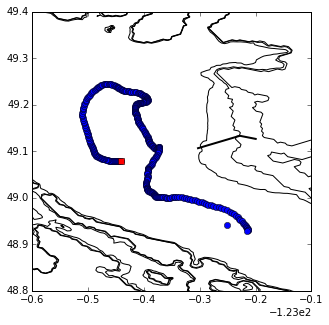

In [14]:
buoy=0
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])


## Buoy 2 - Drop 1

On Sept 19, Buoy 2 was released with Buoy 1. Same starting time and position and duration. So it should do the same thing as first buoy.

UBC-I-0002
Released 2014-09-19 10:20:08.999997 at 49.0794016667 , -123.44245 for 55.6663888889 hours
NEMO coords: 432 269


(48.8, 49.4)

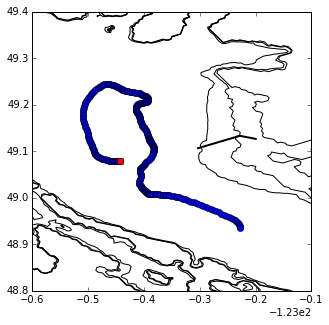

In [15]:
buoy=1
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Buoy 3 - Drop 1

On Sept 19, Buoy 3 was released with Buoy 1 and 2 but then was removed after 11 hours. It was also released on Sept 20 and 21.

UBC-I-0003
Released 2014-09-19 10:20:08.999997 at 49.0793866667 , -123.442943333 for 11.1675000006 hours
NEMO coords: 432 269


(48.8, 49.4)

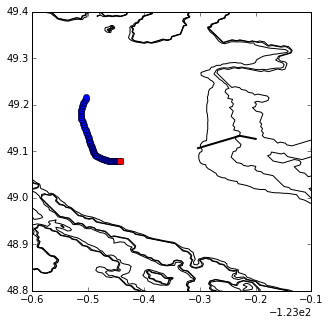

In [16]:
buoy=2
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Buoy 4 - Drop 2

Buoy 4: was released on Sept 19 at 11:40am for 10 hours at pretty much the same location as Buoy 1,2,3

UBC-I-0004
Released 2014-09-19 11:40:07.999998 at 49.0783233333 , -123.441393333 for 9.83361111306 hours
NEMO coords: 432 269


(48.8, 49.4)

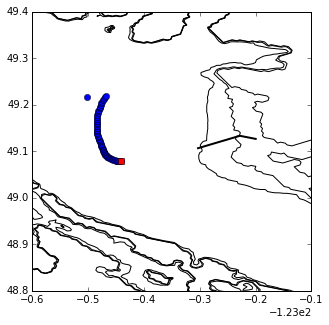

In [17]:
buoy=3
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])


## Buoy 5 - Drop 2

Released on Sept 19 at 11:40 for 54 hours. Same drop point as above

UBC-I-0005
Released 2014-09-19 11:40:07.999998 at 49.0782866667 , -123.441641667 for 53.6747222236 hours
NEMO coords: 432 269


(48.8, 49.4)

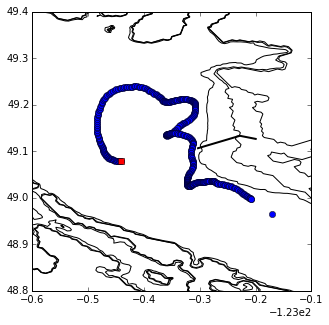

In [18]:
buoy=4
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])


## Buoy 6 - Drop 2

Sept 19 at 11:40am, same location for about 10 hours

UBC-I-0006
Released 2014-09-19 11:40:07.999998 at 49.0780116667 , -123.441743333 for 9.666944445 hours
NEMO coords: 432 269


(48.8, 49.4)

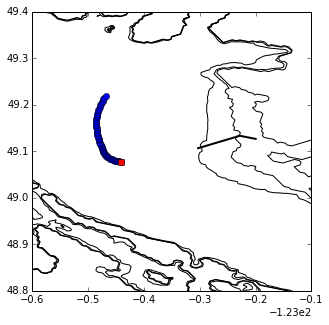

In [19]:
buoy=5
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])


## Buoy 7 - Drop 3

Sept 19 at 13:10 for 8 hours. Same drop location

UBC-I-0007
Released 2014-09-19 13:10:07.999998 at 49.0804766667 , -123.44053 for 8.00000000083 hours
NEMO coords: 433 269


(48.8, 49.4)

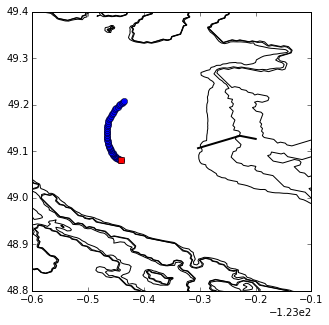

In [20]:
buoy=6
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Buoy 8 - Drop 3

UBC-I-0008
Released 2014-09-19 13:10:07.999998 at 49.0803516667 , -123.440405 for 8.00000000083 hours
NEMO coords: 433 269


(48.8, 49.4)

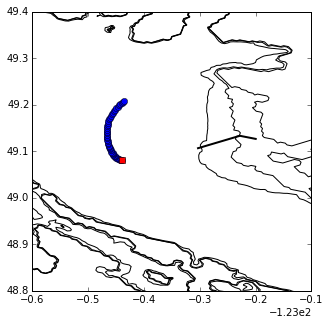

In [21]:
buoy=7
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Buoy 9 - Drop 3

Sept 19 at 13:10 for 54 hours. Similar drop location

UBC-I-0009
Released 2014-09-19 13:10:09.000003 at 49.0802733333 , -123.440366667 for 53.6663888878 hours
NEMO coords: 433 269


(48.8, 49.4)

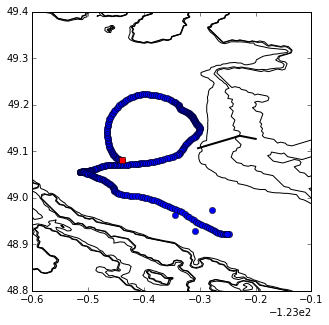

In [22]:
buoy=8
name, tracks=organize_info(buoy,ubc)
fig,ax = plt.subplots(1,1,figsize=(5,5))
print name
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,19))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Tides

Look quickly at the tides on Sept 19.

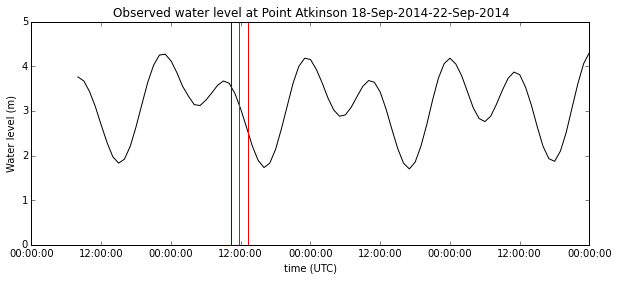

In [23]:

fig,ax=plt.subplots(1,1,figsize=(10,4))

t1=dt.datetime(2014,9,19,10,20)
t2=dt.datetime(2014,9,19,11,40)
t3=dt.datetime(2014,9,19,13,10)
release_times=[t1,t2,t3];
plot_tides(ax,release_times,'18-Sep-2014', '22-Sep-2014')

So drifters where relased during an ebb tide? Check with Rich. Why did they initially go north west then? Winds?

## Winds

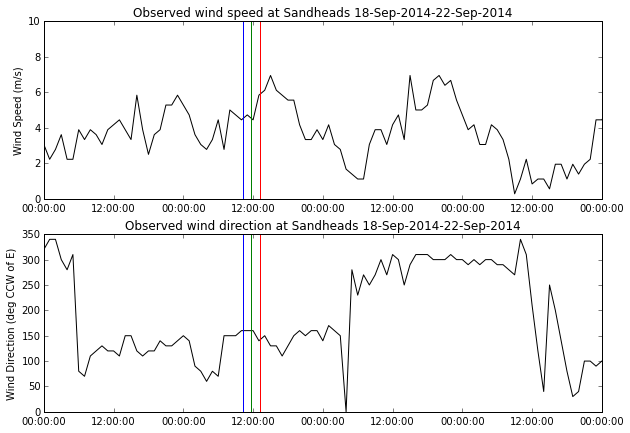

In [24]:
fig,axs = plt.subplots(2,1,figsize=(10,7))
plot_winds(axs[0],axs[1],release_times,'18-Sep-2014', '22-Sep-2014')

So winds were towards the north west. 

# September 20

## Drop 1

### Buoy 3

UBC-I-0003
Released 2014-09-20 04:40:08.999996 at 49.0754766667 , -123.439433333 for 12.5005555561 hours
NEMO coords: 431 269


(48.8, 49.4)

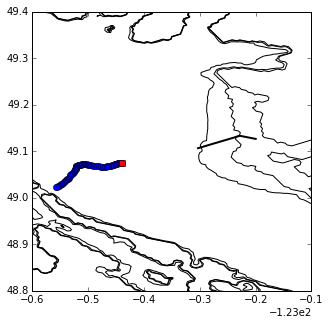

In [25]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,20))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

### Buoy 4

UBC-I-0004
Released 2014-09-20 04:40:08.000001 at 49.0755083333 , -123.439546667 for 12.5000000011 hours
NEMO coords: 431 269


(48.8, 49.4)

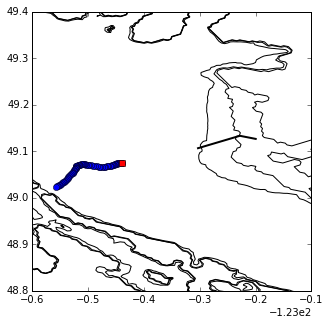

In [26]:
buoy = 3
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,20))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Drop 2

### Buoy 7

UBC-I-0007
Released 2014-09-20 11:10:08.000005 at 49.0787216667 , -123.441358333 for 6.83361111 hours
NEMO coords: 432 269


(48.8, 49.4)

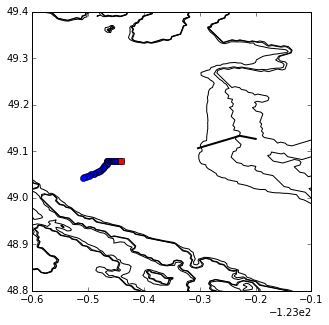

In [27]:
buoy = 6
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj =plot_buoy(ax,tracks,dt.datetime(2014,9,20))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

### Buoy 6

UBC-I-0006
Released 2014-09-20 11:20:07.999999 at 49.0793333333 , -123.4434 for 6.83361111028 hours
NEMO coords: 432 269


(48.8, 49.4)

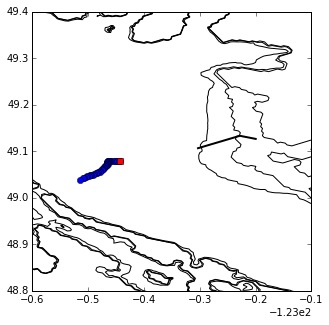

In [28]:
buoy = 5
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj =plot_buoy(ax,tracks,dt.datetime(2014,9,20),i=0)
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Drop 3

### Buoy 8

UBC-I-0008
Released 2014-09-20 13:20:08.999997 at 49.0768533333 , -123.44025 for 5.33305555778 hours
NEMO coords: 432 268


(48.8, 49.4)

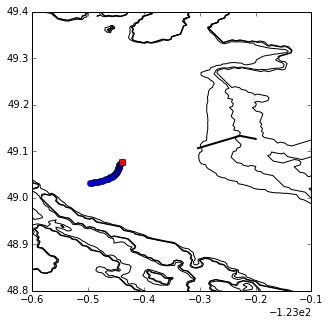

In [29]:
buoy = 7
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,20))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

### Buoy 10

UBC-I-0010
Released 2014-09-20 13:20:08.000002 at 49.0767216667 , -123.440253333 for 5.33333333417 hours
NEMO coords: 432 268


(48.8, 49.4)

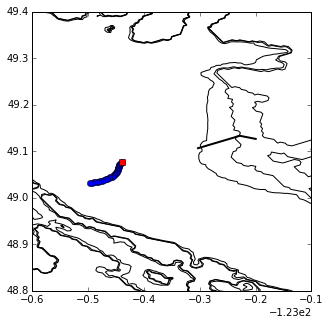

In [30]:
buoy = 9
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,20))
ax.set_xlim([-123.6,-123.1])
ax.set_ylim([48.8,49.4])

## Tides and Winds

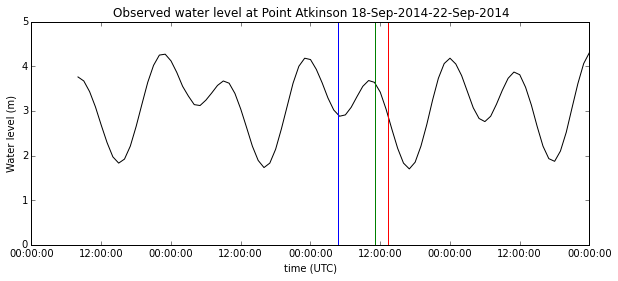

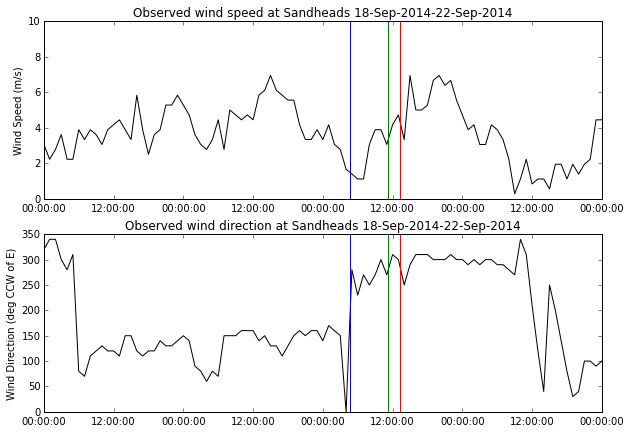

In [31]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
t1=dt.datetime(2014,9,20,4,40)
t2=dt.datetime(2014,9,20,11,10)
t3=dt.datetime(2014,9,20,13,20)
release_times=[t1,t2,t3];
#tides
plot_tides(ax,release_times,'18-Sep-2014', '22-Sep-2014')
#winds
fig,axs = plt.subplots(2,1,figsize=(10,7))
plot_winds(axs[0],axs[1],release_times,'18-Sep-2014', '22-Sep-2014')


# Late Sept 20 to Sept 21

UBC-I-0006
Released 2014-09-20 20:20:07.999999 at 49.0969733333 , -123.312955 for 21.5080555547 hours
NEMO coords: 427 290


(48.8, 49.4)

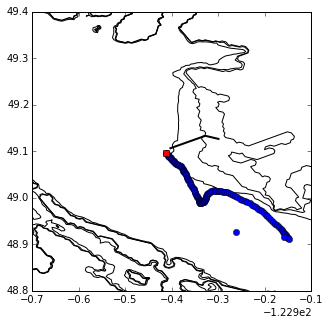

In [32]:
buoy = 5
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,20),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

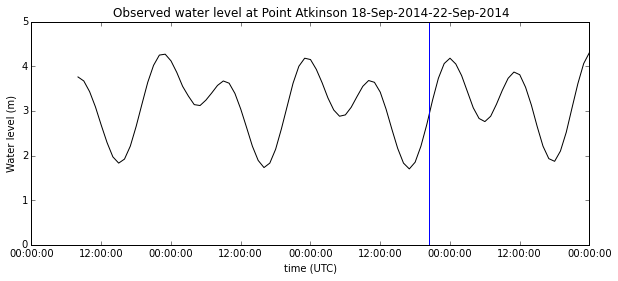

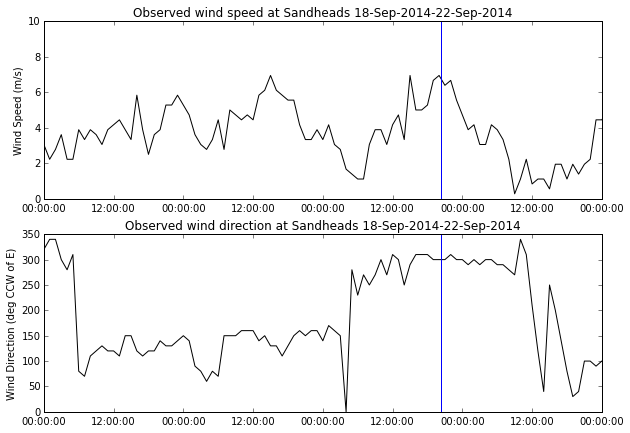

In [33]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
t1=dt.datetime(2014,9,20,20,20)
release_times=[t1];
#tides
plot_tides(ax,release_times,'18-Sep-2014', '22-Sep-2014')
#winds
fig,axs = plt.subplots(2,1,figsize=(10,7))
plot_winds(axs[0],axs[1],release_times,'18-Sep-2014', '22-Sep-2014')

Winds were strongish and southeast.

# September 21

## Buoy 10

UBC-I-0010
Released 2014-09-21 06:30:09.000005 at 49.0710983333 , -123.311388333 for 12.3338888883 hours
NEMO coords: 422 287


(48.8, 49.4)

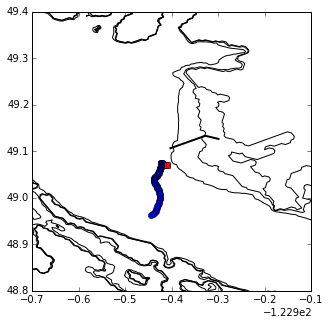

In [34]:
buoy = 9
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,21))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Buoy 8

UBC-I-0008
Released 2014-09-21 08:50:08.999997 at 49.0574933333 , -123.354403333 for 9.83361111306 hours
NEMO coords: 422 279


(48.8, 49.4)

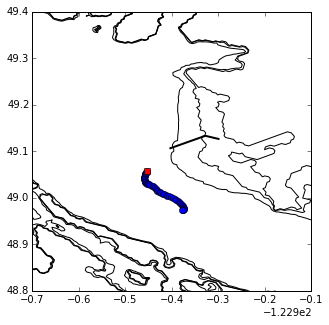

In [35]:
buoy = 7
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,21))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Buoy 7

UBC-I-0007
Released 2014-09-21 09:10:06.999997 at 49.0447116667 , -123.403411667 for 9.00027777889 hours
NEMO coords: 423 270


(48.8, 49.4)

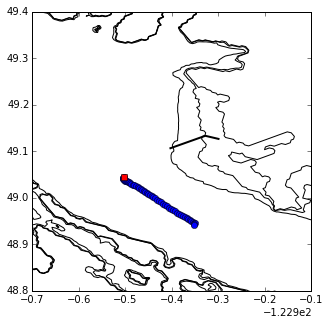

In [36]:
buoy = 6
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,21))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Buoy 4

UBC-I-0004
Released 2014-09-21 09:30:08 at 49.0316116667 , -123.448503333 for 9.16722222333 hours
NEMO coords: 424 262


(48.8, 49.4)

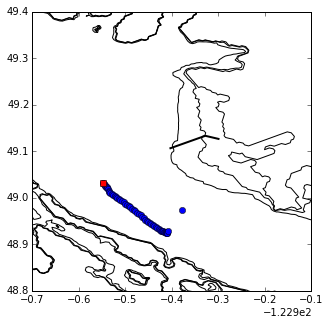

In [37]:
buoy = 3
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,21))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Buoy 3

UBC-I-0003
Released 2014-09-21 10:00:08.000004 at 49.0190616667 , -123.490253333 for 9.16749999944 hours
NEMO coords: 424 254


(48.8, 49.4)

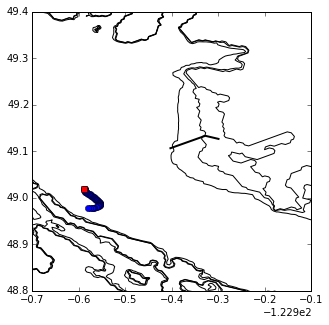

In [38]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,9,21))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

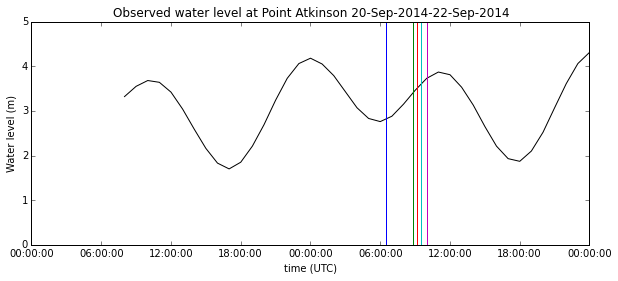

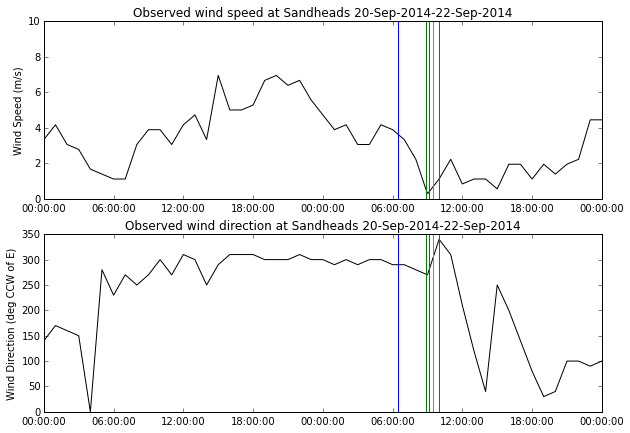

In [39]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
t1=dt.datetime(2014,9,21,6,30)
t2=dt.datetime(2014,9,21,8,50)
t3=dt.datetime(2014,9,21,9,10)
t4=dt.datetime(2014,9,21,9,30)
t5=dt.datetime(2014,9,21,10,0)
release_times=[t1,t2,t3,t4,t5];
#tides
plot_tides(ax,release_times,'20-Sep-2014', '22-Sep-2014')
#winds
fig,axs = plt.subplots(2,1,figsize=(10,7))
plot_winds(axs[0],axs[1],release_times,'20-Sep-2014', '22-Sep-2014')

Vertical lines are the start times of the various drops.

# October 8

## Drop 1

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.7502777783 hours


(48.8, 49.4)

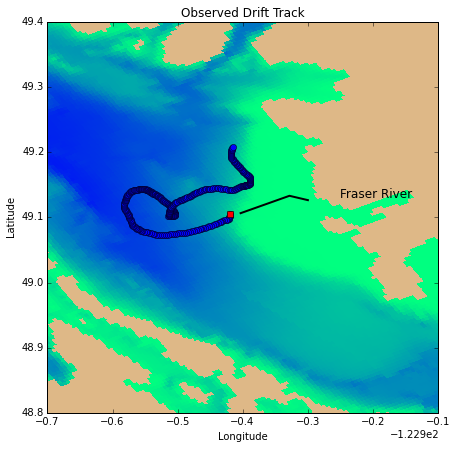

In [73]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(7,7))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8), fancy=True)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])


In [ ]:
buoy = 2
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.2499999981 hours
NEMO coords: 429 290


(48.8, 49.4)

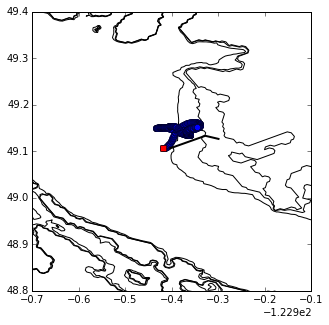

In [41]:
buoy = 3
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])


UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.66666666611 hours
NEMO coords: 429 290


(48.8, 49.4)

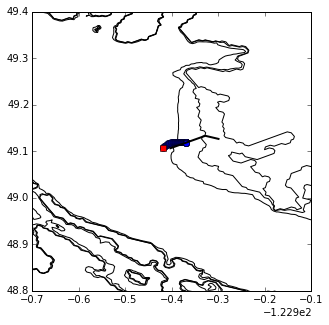

In [42]:
buoy = 9
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8))
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Drop 2

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.4997222228 hours
NEMO coords: 427 288


(48.8, 49.4)

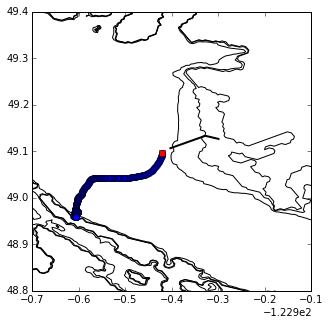

In [43]:
buoy = 1
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

In [ ]:
buoy = 4
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

In [ ]:
buoy = 7
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

## Drop 3

In [ ]:
buoy = 0
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

In [ ]:
buoy = 5
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

In [ ]:
buoy = 6
name, tracks=organize_info(buoy,ubc)
print name
fig,ax = plt.subplots(1,1,figsize=(5,5))
traj=plot_buoy(ax,tracks,dt.datetime(2014,10,8),i=-1)
ax.set_xlim([-123.6,-123])
ax.set_ylim([48.8,49.4])

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
t1=dt.datetime(2014,10,8,16,0)
t2=dt.datetime(2014,10,8,17,30)
t3=dt.datetime(2014,10,8,19,0)
release_times=[t1,t2,t3];
#tides
plot_tides(ax,release_times,'6-Oct-2014', '10-Oct-2014')
#winds
fig,axs = plt.subplots(2,1,figsize=(10,7))
plot_winds(axs[0],axs[1],release_times,'6-Oct-2014', '10-Oct-2014')

# Summary

** September 19**

Release 3 particles with the following paramters

1. NEMO coords (j,i): 432,269 at 10:20 for 11 hours
2. NEMO coords (j,i): 432,269 at 11:40 for 10 hours
3. NEMO coords (j,i): 433,269 at 13:10 for 8 hours

** September 20**

Release 3 particles with the following parameters

1. NEMO coords (j,i): 431,269 at 4:40 for 13 hours
2. NEMO coords (j,i): 432,269 at 11:10 for 7 hours
3. NEMO coords (j,i): 432,268 at 13:20 for 6 hours

** Late September 20**

1. NEMO coords (j,i): 427,290 at 20:20 for 22 hours 

** September 21**

1. NEMO coords (j,i): 422,287 at 06:30 for 12 hours  (UBC 10)
2. NEMO coords (j,i): 422,279 at 08:50 for 10 hours  (UBC 8)
3. NEMO coords (j,i): 423,270 at 09:10 for 9 hours  (UBC 7)
4. NEMO coords (j,i): 424,262 at 09:30 for 9 hours  (UBC 4)
5. NEMO coords (j,i): 424,254 at 10:00 for 9 hours  (UBC 3)

** October 8**

Drop 1
1. UBC-I-0003  - NEMO coods (j,i): 429, 290 at 16:00 hours for 29 hours
2. UBC-I-0004  - NEMO coods (j,i): 429, 290 at 17:30 hours for 29 hours
3. UBC-I-0010  - NEMO coods (j,i): 429, 290 at 19:30 hours for 7 hours 

Drop 2
1. UBC-I-0002  - NEMO coods (j,i): 427, 288 at 16:00 hours for 27 hours
2. UBC-I-0005  - NEMO coods (j,i): 427, 289 at 17:30 hours for 27 hours
3. UBC-I-0008  - NEMO coods (j,i): 427, 289 at 19:30 hours for 25 hours (Note: find_model_point returned empty, but the lat/lon are similar to UBC-I-0005 so I used that one. perhaps tolerance is to restricitve on find_model_point)

Drop 3
1. UBC-I-0001  - NEMO coods (j,i): 425, 287 at 16:00 hours for 27 hours
2. UBC-I-0006  - NEMO coods (j,i): 425, 287 at 17:30 hours for 24 hours 
3. UBC-I-0007 -  NEMO coods (j,i): 425, 287 at 19:00 hours for 24 hours

Note: Mark's email indicated UBC-I-0006 was released in the "Drop 1" group and UBC-I-0004 was released in the "Drop 3" group. I have it the other way around..

# Next Steps

1.Possibly create a drifters.py module to streamline analysis